In [3]:
# Move to repo root
target_folder = "NCEAS_Unsupervised_NLP"
current_dir = os.getcwd()

while os.path.basename(current_dir) != target_folder:
    parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
    if parent_dir == current_dir:
        raise FileNotFoundError(f"{target_folder} not found.")
    current_dir = parent_dir

os.chdir(current_dir)

# Add repo root
sys.path.insert(0, current_dir)

# Add src so custom_packages works
sys.path.insert(0, os.path.join(current_dir, "src"))

In [4]:
# IMPORTS
# Standard Imports
import os
import sys
import re
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
import phate
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, rand_score
from hdbscan import HDBSCAN

from custom_packages.diffusion_condensation import DiffusionCondensation as dc
from custom_packages.fowlkes_mallows import FowlkesMallows

warnings.filterwarnings("ignore")
np.random.seed(42)



# Load arXiv Dataset

In [5]:
import pandas as pd
df = pd.read_csv("src/data/arxiv/data/arxiv/arxiv_30k_clean.csv")
df_new = pd.DataFrame()
df_new["topic"] = df["text"]
df_new["category_1"] = df["label"]
df_new["category_0"] = df["label"].apply(lambda x: x.split(".")[0])

df_new = df_new.dropna().reset_index(drop=True)


In [6]:
df_new = df_new.dropna().reset_index(drop=True)

df_new = df_new[
    df_new["topic"].apply(lambda x: isinstance(x, str) and x.strip() != "")
].reset_index(drop=True)


In [7]:
df_new.to_csv("src/data/arxiv/arxiv_clean.csv", index=False)

In [8]:
df_new.shape

(30000, 3)

# Embedding

In [9]:
dataset_name = "arxiv"
embedding_model = "Qwen3-Embedding-0.6B"

embed_path = "src/data/arxiv/arxiv_qwen_embeddings.npy"

embedding_list = np.load(embed_path)

print("Embedding shape:", embedding_list.shape)


Embedding shape: (30000, 1024)


# Shuffle

In [10]:
embedding_list.shape[0] == len(df_new)
shuffle_idx = np.random.RandomState(seed=42).permutation(len(df_new))
# Shuffle both documents and embeddings using the same index
topic_data = df_new.iloc[shuffle_idx].reset_index(drop=True)
data = np.array(embedding_list)[shuffle_idx] 
reverse_idx = np.argsort(shuffle_idx)
print("Data shape after shuffle:", data.shape)

Data shape after shuffle: (30000, 1024)


In [11]:
print(topic_data.columns)


Index(['topic', 'category_1', 'category_0'], dtype='object')


In [12]:
topic_dict = {}
for col in topic_data.columns:
    if re.match(r'^category_\d+$', col): 
        unique_count = len(topic_data[col].unique())
        topic_dict[unique_count] = np.array(topic_data[col])

In [36]:
reducer_model = phate.PHATE(n_jobs=-2,random_state=42, n_components=300,decay=20,t="auto",n_pca=None) #{'k':10,'alpha':4,'t':3}
embed_phate = reducer_model.fit_transform(data)
np.save(
    f"{embedding_model}_reduced_embeddings/PHATE_{dataset_name}_embed.npy",
    embed_phate
)


Calculating PHATE...
  Running PHATE on 30000 observations and 1024 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 15.22 seconds.
    Calculating affinities...
    Calculated affinities in 18.04 seconds.
  Calculated graph and diffusion operator in 33.54 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 13.32 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.64 seconds.
  Calculated landmark operator in 16.96 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 2.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -3.9% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 86.91 seconds.
Calculated PHATE in 142.89 seconds.


In [37]:
embed_phate = np.load(
    f"{embedding_model}_reduced_embeddings/PHATE_arxiv_embed.npy"
)


 # Build Hierarchy Levels

In [13]:
depth= 2
cluster_levels=[]
for i in reversed(range(0, depth)):
    cluster_levels.append(len(topic_data[f'category_{i}'].unique()))

In [15]:
import numpy as np

embedding_methods = {}

embedding_methods["PHATE"] = np.load(
    "Qwen3-Embedding-0.6B_reduced_embeddings/PHATE_arxiv_embed.npy"
)

embedding_methods["PCA"] = np.load(
    "Qwen3-Embedding-0.6B_reduced_embeddings/PCA_arxiv_embed.npy"
)

embedding_methods["UMAP"] = np.load(
    "Qwen3-Embedding-0.6B_reduced_embeddings/UMAP_arxiv_embed.npy"
)


# did this in HPCC

import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

include_pca = True
include_umap = True

# Convert embeddings
embeddings = np.array(data)

embedding_methods = {}

# =====================
# PHATE (already computed)
# =====================
embedding_methods["PHATE"] = embed_phate

np.save(
    f"{embedding_model}_reduced_embeddings/PHATE_{dataset_name}_embed.npy",
    embedding_methods["PHATE"]
)

# =====================
# PCA
# =====================
if include_pca:
    pca = PCA(n_components=50, random_state=42)
    embedding_methods["PCA"] = pca.fit_transform(embeddings)

    np.save(
        f"{embedding_model}_reduced_embeddings/PCA_{dataset_name}_embed.npy",
        embedding_methods["PCA"]
    )

# =====================
# UMAP
# =====================
if include_umap:
    umap_model = umap.UMAP(
        n_components=50,
        random_state=42,
        min_dist=0.05,
        n_neighbors=10
    )

    embedding_methods["UMAP"] = umap_model.fit_transform(embeddings)

    np.save(
        f"{embedding_model}_reduced_embeddings/UMAP_{dataset_name}_embed.npy",
        embedding_methods["UMAP"]
    )

# =====================
# Optional: t-SNE
# =====================
# from sklearn.manifold import TSNE
# tsne_model = TSNE(n_components=3, random_state=42)
# embedding_methods["tSNE"] = tsne_model.fit_transform(embeddings)
# np.save(
#     f"{embedding_model}_reduced_embeddings/tSNE_{dataset_name}_embed.npy",
#     embedding_methods["tSNE"]
# )

import hdbscan
scores_all = defaultdict(lambda: defaultdict(list))

for embed_name, embed_data in tqdm(embedding_methods.items()):
    for cluster_method in ["Agglomerative", "HDBSCAN", "DC"]:
        for level in cluster_levels:

            # -----------------
            # Clustering
            # -----------------
            if cluster_method == "Agglomerative":
                model = AgglomerativeClustering(n_clusters=level)
                model.fit(embed_data)
                labels = model.labels_

            elif cluster_method == "HDBSCAN":
                model = HDBSCAN(min_cluster_size=level)
                model.fit(embed_data)

                Z = model.single_linkage_tree_.to_numpy()
                labels = fcluster(Z, level, criterion='maxclust')
                labels[labels == -1] = labels.max() + 1

            elif cluster_method == "DC":
                model = dc(min_clusters=level, max_iterations=5000, k=10, alpha=3)
                model.fit(embed_data)
                labels = model.labels_

            # -----------------
            # Match ground truth
            # -----------------
            available_levels = np.array(sorted(topic_dict.keys()))
            closest_level = min(available_levels, key=lambda k: abs(k - level))

            topic_series = topic_dict[closest_level]
            valid_idx = ~pd.isna(topic_series)

            target_lst = topic_series[valid_idx]
            label_lst = labels[valid_idx]

            # -----------------
            # Metrics
            # -----------------
            try:
                fm_score = FowlkesMallows.Bk(
                    {level: target_lst},
                    {level: label_lst}
                )[level]["FM"]
            except:
                fm_score = np.nan

            scores_all[(embed_name, cluster_method)]["FM"].append(fm_score)
            scores_all[(embed_name, cluster_method)]["Rand"].append(
                rand_score(target_lst, label_lst)
            )
            scores_all[(embed_name, cluster_method)]["ARI"].append(
                adjusted_rand_score(target_lst, label_lst)
            )

rows = []

for (embed_name, cluster_method), score_dict in scores_all.items():
    n_levels = len(score_dict["FM"])

    for i in range(n_levels):
        rows.append({
            "reduction_method": embed_name,
            "cluster_method": cluster_method,
            "level": cluster_levels[i],
            "FM": score_dict["FM"][i],
            "Rand": score_dict["Rand"][i],
            "ARI": score_dict["ARI"][i],
        })

scores_df = pd.DataFrame(rows)

scores_df = scores_df.sort_values(
    by=["reduction_method", "cluster_method", "level"]
).reset_index(drop=True)

write_header = not os.path.exists(
    f"{embedding_model}_results/other_{dataset_name}_results.csv"
)

scores_df.to_csv(
    f"{embedding_model}_results/other_{dataset_name}_results.csv",
    mode="a",
    index=False,
    header=write_header
)

import json
with open("combo_color_map.json", 'r') as file:
        combo_color_map = json.load(file)

  reduction_method cluster_method  level        FM      Rand       ARI
0              PCA  Agglomerative      2  0.933393  0.911201  0.800560
1              PCA  Agglomerative     62  0.213036  0.933818  0.157418
2              PCA             DC      2  0.591714  0.506226 -0.016413
3              PCA             DC     62  0.226867  0.917260  0.181618
4              PCA        HDBSCAN      2  0.810250  0.656527 -0.000048


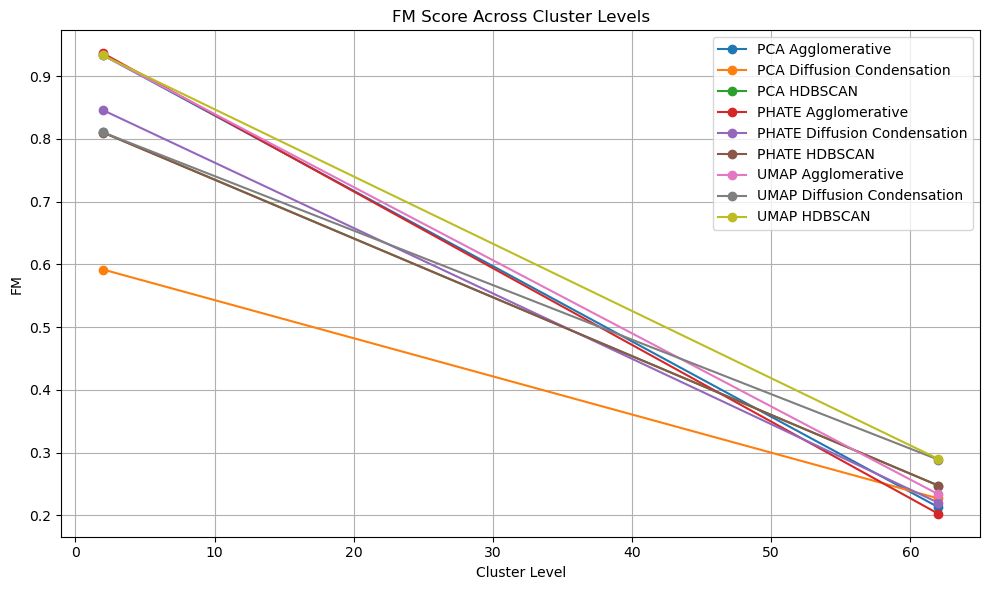

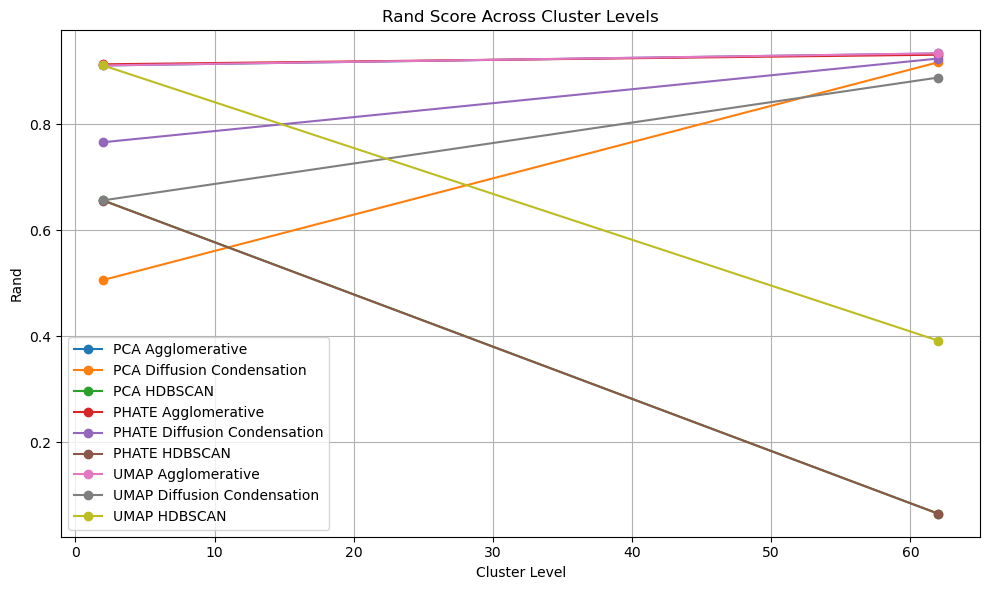

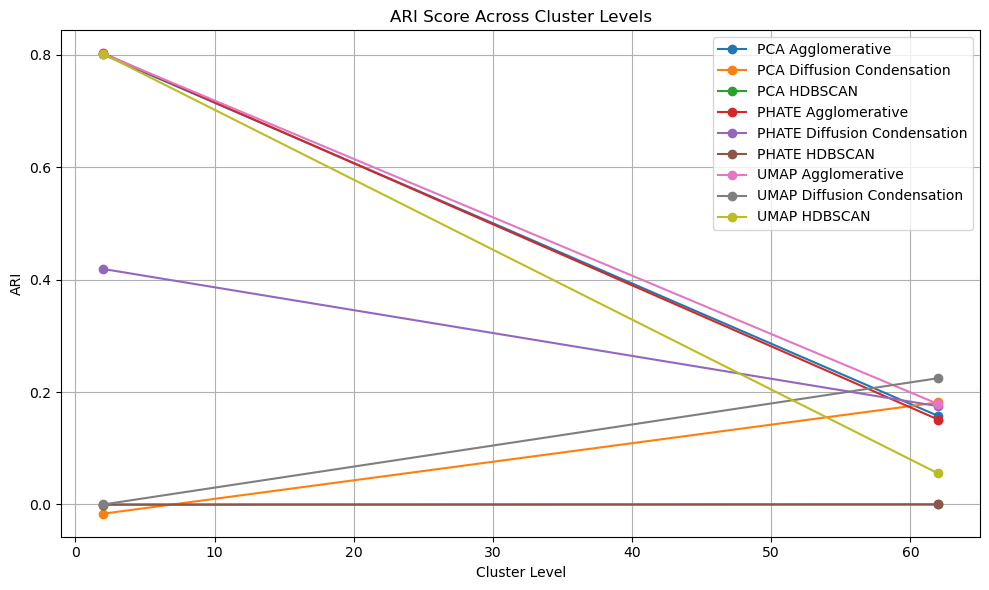

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
scores_df = pd.read_csv(
    "src/data/arxiv/src/data/arxiv/other_arxiv_results.csv"
)

print(scores_df.head())

metrics = ["FM", "Rand", "ARI"]

for metric in metrics:
    plt.figure(figsize=(10, 6))

    for (reduction, method), group in scores_df.groupby(
        ["reduction_method", "cluster_method"]
    ):
        if method == "DC":
            method = "Diffusion Condensation"

        plt.plot(
            group["level"],
            group[metric],
            marker='o',
            label=f"{reduction} {method}"
        )

    plt.title(f"{metric} Score Across Cluster Levels")
    plt.xlabel("Cluster Level")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
